In [2]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from robust_pca import r_pca


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

from diff_classifier.features import alpha_calc, unmask_track
from diff_predictor.utils import plot_msd_comparisons, plot_individual_msds, plot_particles_in_frame

import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy.ma as ma

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [3]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [4]:
#load paths to data

age_feature_path = workbookDir + '/data/raw_data_age/'
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'feat' in f]
print(len(age_feature_filelist))

age_msd_path = workbookDir + '/raw_data_age/'
age_msd_filelist = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd' in f]
print(len(age_msd_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f)) and 'msd' in f]
print(len(treatment_filelist))

75
74
38
180


In [5]:
fstats_tot_age = data_process.generate_fullstats(age_feature_path, age_feature_filelist, ['P14','P35', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P35_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file features_P35_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P35_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P35_brain_2_slice_1_vid_3.csv size: (1017, 91)
A

In [6]:
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [7]:
ecm = fstats_tot_age[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [8]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [15]:
bal_ecm = bal_ecm.reset_index(drop=True)
bal_ecm

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean MSD_ratio,Mean Deff1,Mean Deff2,age,Track_ID,X,Y,binx,biny,bins
0,0.191301,10.375955,1.624233,0.059493,0.779635,0.007696,1.738722,0.424865,0.093556,1.820677,...,0.568034,4.503660,0.583820,P70,93.0,1953.582603,1360.648877,15,10,250
1,3.415278,0.001613,3.882279,0.476458,0.428077,0.083592,1.669337,0.400960,0.032883,1.556931,...,0.628107,2.888546,NaN,P70,687.0,1425.469609,1876.162108,11,14,190
2,1.533167,0.360403,4.600245,0.171344,0.643809,0.023757,1.352515,0.260637,0.096580,2.025527,...,0.381480,4.912801,NaN,P70,1430.0,781.061968,1231.417411,6,9,105
3,1.875880,0.141658,2.208316,0.711645,0.291273,0.163253,2.275138,0.560466,0.024567,1.450461,...,0.269514,2.279252,NaN,P70,468.0,1514.562479,1770.893337,11,13,189
4,0.819912,4.283229,2.233269,0.987178,0.056800,0.507969,3.044304,0.671518,0.060647,1.639681,...,1.833806,2.455036,0.309671,P70,572.0,1048.457051,1961.785097,8,15,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,0.146382,32.242243,2.694113,0.765783,0.258099,0.191007,1.767878,0.434350,0.185897,2.181697,...,1.767087,5.963980,NaN,P35,600.0,1034.896173,634.666562,8,4,132
14696,0.141853,48.911378,2.114318,0.778785,0.249848,0.198594,1.284749,0.221638,0.093410,2.264935,...,1.174059,9.110905,NaN,P35,784.0,1678.116269,434.224593,13,3,211
14697,0.558256,23.957170,1.904525,0.726977,0.282040,0.170560,1.102116,0.092655,0.149442,1.562094,...,0.491829,2.254876,0.005316,P35,81.0,893.515944,1677.265461,6,13,109
14698,0.715333,4.912179,3.126657,0.467134,0.433614,0.081256,1.360082,0.264750,0.115362,1.694750,...,0.358126,11.823222,NaN,P35,1202.0,84.384879,816.971621,0,6,6


In [19]:
label_df = bal_ecm[target].copy()
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

In [17]:
from numpy.random import permutation
perm = permutation(len(label_df))
label_shuffled = label_df[perm]

In [18]:
label_shuffled

14494    P35
10048    P35
185      P70
4057     P70
9461     P14
        ... 
10816    P35
6800     P14
7539     P14
9723     P14
8788     P14
Name: age, Length: 14700, dtype: object

In [25]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(label_shuffled)

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [26]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [27]:
best_param = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [28]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=96, verbose=False)

Accuracy: 0.33785942492012777


In [29]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.3427    0.3726    0.3570      1248
         P35     0.3274    0.3679    0.3464      1245
         P70     0.3460    0.2740    0.3058      1263

    accuracy                         0.3379      3756
   macro avg     0.3387    0.3381    0.3364      3756
weighted avg     0.3387    0.3379    0.3363      3756



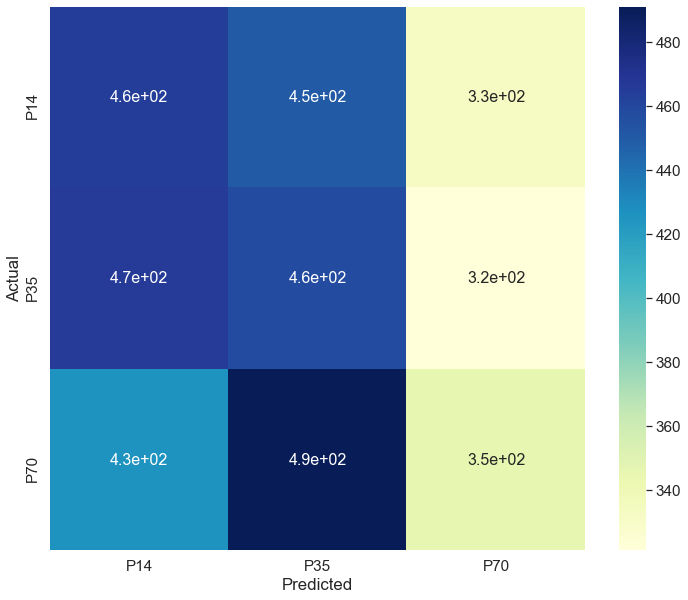

In [30]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

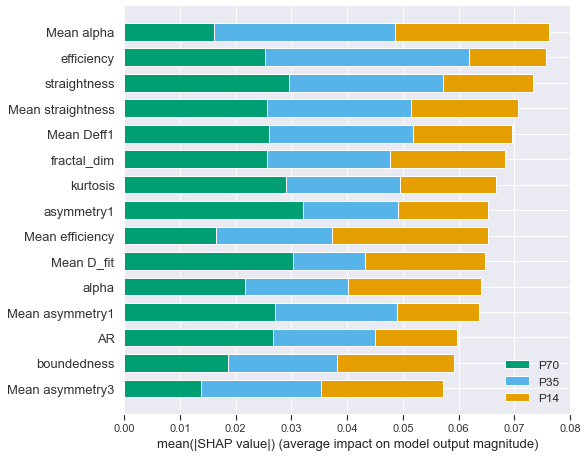

In [31]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)